# Import dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense

# Prepare the data

In [2]:
data = pd.read_csv("../collected_data/prepared_data/pre_and_post_step_data.csv")
data_diff = pd.read_csv("../collected_data/prepared_data/diff_step_data.csv")

array([[<AxesSubplot: title={'center': 'steps_time'}>,
        <AxesSubplot: title={'center': 'vertices_pre'}>,
        <AxesSubplot: title={'center': 'redexes_pre'}>],
       [<AxesSubplot: title={'center': 'heights_pre'}>,
        <AxesSubplot: title={'center': 'widths_pre'}>,
        <AxesSubplot: title={'center': 'vertices_post'}>],
       [<AxesSubplot: title={'center': 'redexes_post'}>,
        <AxesSubplot: title={'center': 'heights_post'}>,
        <AxesSubplot: title={'center': 'widths_post'}>],
       [<AxesSubplot: title={'center': 'redex_depths'}>, <AxesSubplot: >,
        <AxesSubplot: >]], dtype=object)

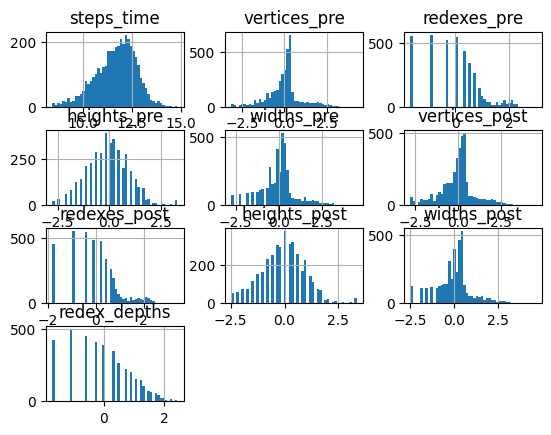

In [3]:
power_trans = PowerTransformer(method='yeo-johnson')

data_norm = pd.DataFrame()
for col_name in ['steps_time']:
    norm_col_data = np.log(data[col_name])
    data_norm[col_name] = norm_col_data

for col_name in ['vertices_pre', 'redexes_pre', 'heights_pre', 'widths_pre',
                 'vertices_post', 'redexes_post', 'heights_post', 'widths_post', 'redex_depths']:
    norm_col_data = power_trans.fit_transform(np.array(data[col_name]).reshape(-1, 1))
    data_norm[col_name] = list(norm_col_data.reshape(1, -1))[0]

data_norm.hist(bins=50)

In [4]:
data_for_training = data_norm.copy(deep=True)

In [5]:
for col_name in ['vertices_dif', 'redexes_dif', 'heights_dif', 'widths_dif']:
    norm_col_data = np.array(data_diff[col_name])
    norm_col_data = power_trans.fit_transform(norm_col_data.reshape(-1, 1))
    data_for_training[col_name] = list(norm_col_data.reshape(1, -1)[0])

    norm_col_data = np.array(np.abs(data_diff[col_name]))
    norm_col_data = power_trans.fit_transform(norm_col_data.reshape(-1, 1))
    data_for_training[col_name + "abs_norm"] = list(norm_col_data.reshape(1, -1)[0])

    norm_col_data = np.array(np.power(data_diff[col_name], 2))
    norm_col_data = power_trans.fit_transform(norm_col_data.reshape(-1, 1))
    data_for_training[col_name + "pow2_norm"] = list(norm_col_data.reshape(1, -1)[0])

In [6]:
def split_dataset(dataset, test_ratio=0.3):
    test_indices_filter = np.random.rand(len(dataset)) < test_ratio
    return dataset[~test_indices_filter], dataset[test_indices_filter]


train_ds, test_ds = split_dataset(data_for_training)
print(f"Examples for training {len(train_ds)}")
print(f"Examples for testing {len(test_ds)}")

Examples for training 2703
Examples for testing 1228


In [7]:
x_train, y_train = train_ds.drop("steps_time", axis=1), train_ds[["steps_time"]]
x_test, y_test = test_ds.drop("steps_time", axis=1), test_ds[["steps_time"]]
x_data, y_data = data_for_training.drop("steps_time", axis=1), data_for_training[["steps_time"]]

In [8]:
rcParams['figure.figsize'] = 10, 9


def draw_pred_lines(y_pred, y_real):
    drawing_df = pd.DataFrame({"Pred": y_pred, "Real": y_real})
    drawing_df = drawing_df.sort_values("Real").reset_index(drop=True)

    for key_, val_ in drawing_df.items():
        plt.plot(range(len(val_)), val_, label=key_)

    plt.xlabel("No")
    plt.ylabel("Step Time")
    plt.title("Pred vs Real Step Time")
    plt.legend()
    plt.show()

# Train the ANN Regression

In [87]:
model = Sequential()
units = 256

model.add(Dense(units=units, activation='relu', input_dim=21))  # 1
model.add(Dense(units=units, activation='relu'))    # 2
model.add(Dense(units=units, activation='relu'))
model.add(Dense(units=units, activation='relu'))    # 4
# model.add(Dense(units=units, activation='relu'))
# model.add(Dense(units=units, activation='relu'))    # 6
# model.add(Dense(units=units, activation='relu'))
# model.add(Dense(units=units, activation='relu'))  # 8
# model.add(Dense(units=units, activation='relu'))
# model.add(Dense(units=units, activation='relu'))  # 10
model.add(Dense(units=1))

model.compile(loss='mean_squared_error', optimizer='rmsprop')

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=1)

Epoch 1/20
2703/2703 [==============================] - 4s 1ms/step - loss: 5.3263 - val_loss: 0.8806
Epoch 2/20
2703/2703 [==============================] - 3s 1ms/step - loss: 0.6689 - val_loss: 0.8041
Epoch 3/20
2703/2703 [==============================] - 3s 1ms/step - loss: 0.4382 - val_loss: 0.2987
Epoch 4/20
2703/2703 [==============================] - 3s 1ms/step - loss: 0.3500 - val_loss: 0.4213
Epoch 5/20
2703/2703 [==============================] - 3s 1ms/step - loss: 0.3243 - val_loss: 0.5585
Epoch 6/20
2703/2703 [==============================] - 3s 1ms/step - loss: 0.2938 - val_loss: 0.4586
Epoch 7/20
2703/2703 [==============================] - 3s 1ms/step - loss: 0.2877 - val_loss: 0.2387
Epoch 8/20
2703/2703 [==============================] - 4s 1ms/step - loss: 0.2620 - val_loss: 0.2450
Epoch 9/20
2703/2703 [==============================] - 4s 1ms/step - loss: 0.2485 - val_loss: 0.2625
Epoch 10/20
2703/2703 [==============================] - 3s 1ms/step - loss: 0.232

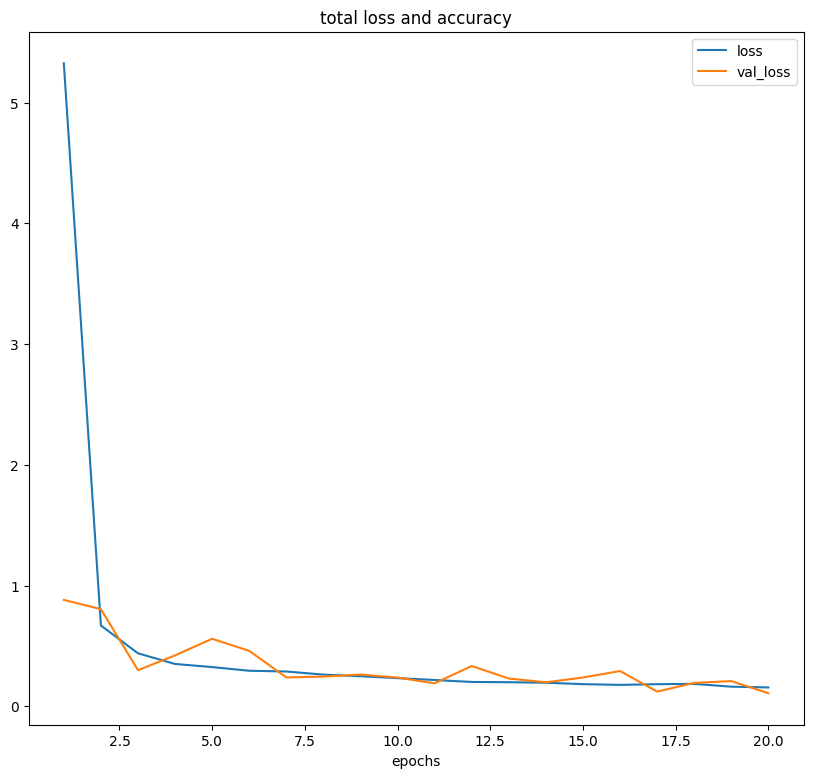

In [88]:
epoch_array = range(1, len(history.history['loss']) + 1)
loss_array = history.history['loss']
val_loss_array = history.history['val_loss']

plt.plot(epoch_array, loss_array, label="loss")
plt.plot(epoch_array, val_loss_array, label="val_loss")
plt.xlabel("epochs")
plt.title("total loss and accuracy")

plt.legend()
plt.show()

In [89]:
y_test_pred = model.predict(x_test)
y_train_pred = model.predict(x_train)
y_data_pred = model.predict(x_data)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
rmse_all = mean_squared_error(y_data, y_data_pred, squared=False)

123/123 [==============================] - 0s 884us/step


TRAIN Root Mean Squared Error(RMSE): 0.3095271008047463
TEST Root Mean Squared Error(RMSE): 0.328177651554185
ALL RMSE: 0.3154717672336285


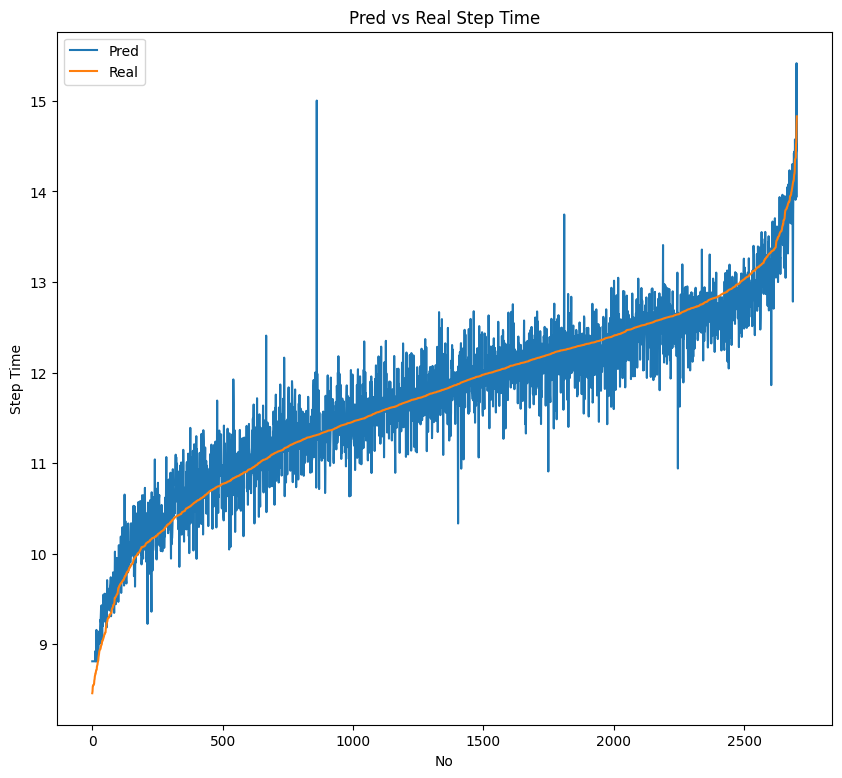

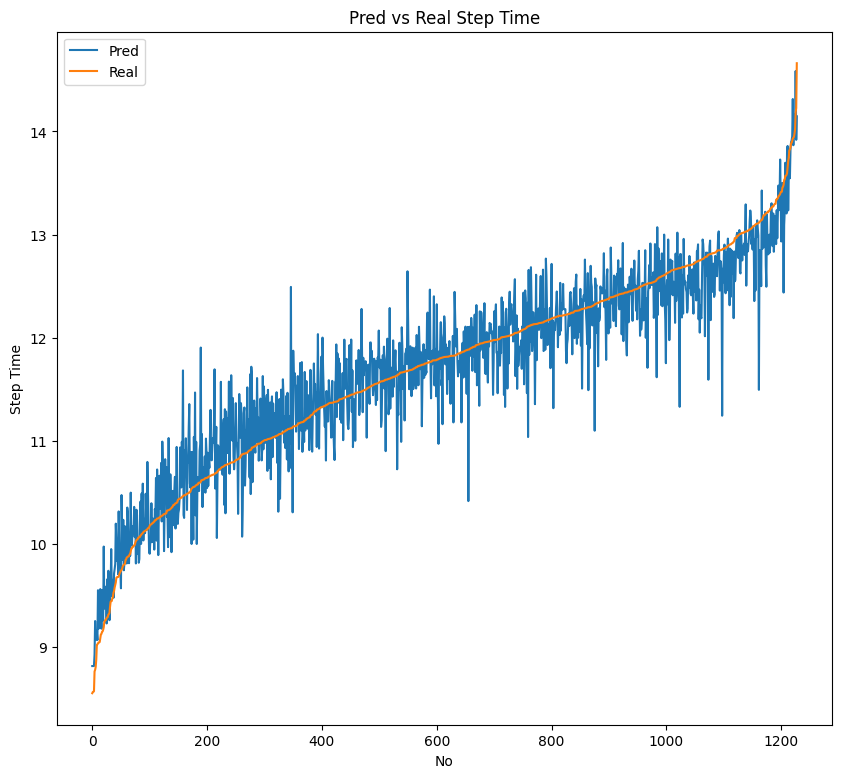

In [90]:
print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)
print("ALL RMSE:", rmse_all)
draw_pred_lines(list(y_train_pred[:, -1]), y_train["steps_time"].to_list())
draw_pred_lines(list(y_test_pred[:, -1]), y_test["steps_time"].to_list())

# Testing procedure

In [98]:
activation_function = 'sigmoid'
units = 64

mse_test_dict = dict()

for layers in [1, 2, 4, 6, 8, 10]:
    model = Sequential()

    model.add(Dense(units=units, activation=activation_function, input_dim=21))  # 1
    if layers > 1:
        for _ in range(layers - 1):
            model.add(Dense(units=units, activation=activation_function))

    model.add(Dense(units=1))

    model.compile(loss='mean_squared_error', optimizer='rmsprop')
    model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=1)

    y_test_pred = model.predict(x_test)
    mse_test = mean_squared_error(y_test, y_test_pred, squared=False)
    mse_test_dict[layers] = mse_test

Epoch 1/20
2703/2703 [==============================] - 4s 1ms/step - loss: 4.6630 - val_loss: 0.1244
Epoch 2/20
2703/2703 [==============================] - 3s 1ms/step - loss: 0.1102 - val_loss: 0.1465
Epoch 3/20
2703/2703 [==============================] - 3s 1ms/step - loss: 0.1059 - val_loss: 0.1119
Epoch 4/20
2703/2703 [==============================] - 3s 1ms/step - loss: 0.1013 - val_loss: 0.1035
Epoch 5/20
2703/2703 [==============================] - 3s 1ms/step - loss: 0.1015 - val_loss: 0.0968
Epoch 6/20
2703/2703 [==============================] - 3s 1ms/step - loss: 0.0960 - val_loss: 0.1019
Epoch 7/20
2703/2703 [==============================] - 3s 1ms/step - loss: 0.0964 - val_loss: 0.0964
Epoch 8/20
2703/2703 [==============================] - 3s 1ms/step - loss: 0.0946 - val_loss: 0.1124
Epoch 9/20
2703/2703 [==============================] - 3s 1ms/step - loss: 0.0945 - val_loss: 0.1046
Epoch 10/20
2703/2703 [==============================] - 3s 1ms/step - loss: 0.092

In [99]:
mse_test_dict

{1: 0.30938623630667733,
 2: 0.3220759245328841,
 4: 0.2914503076408993,
 6: 1.0258096895535882,
 8: 1.0386976587809948,
 10: 1.0217020590781192}